# DeepNeuralNetwork(Application)

![](../picture/16.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

### 1 Load data

In [2]:
def load_data():
    '''
    create train set and test set
    make sure you have .h5 file in your dataset
    
    Returns:
    -------
        train_set_x_orig: original train set shape is (209, 64, 64, 3) 
        train_set_y_orig: original train label shape is (209,)
        test_set_x_orig: original test set shape is (50, 64, 64, 3)
        test_set_y_orig: original test label shape is (50,)
        classes: cat or non-cat.
        
    Note:
    ----
        (209, 64, 64, 3): 209 picture,64 width,64 height,3 channel.
    '''
    train_dataset = h5py.File('../data_set/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('../data_set/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


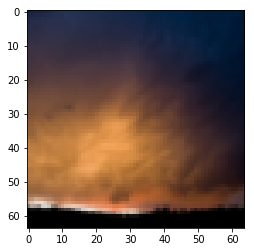

In [4]:
index = 0
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[index]) + ". It's a " + classes[train_y[index]].decode("utf-8") +  " picture.")

#### 1.1 Initialization data

我们需要将数据除以255以达到归一化的效果.

In [5]:
train_x = train_x_orig.reshape(train_x_orig.shape[0],-1).T / 255 
test_x = test_x_orig.reshape(test_x_orig.shape[0],-1).T / 255
train_y = train_y.reshape(-1,1).T
test_y = test_y.reshape(-1,1).T
print('Train_x\'s shape:{}'.format(train_x.shape))
print('Test_x\'s shape:{}'.format(test_x.shape))
print("Train_y's shape:{}".format(train_y.shape))
print("Test_y's shape:{}".format(test_y.shape))

Train_x's shape:(12288, 209)
Test_x's shape:(12288, 50)
Train_y's shape:(1, 209)
Test_y's shape:(1, 50)


### 2 Initialization parameters 

初始化参数我们需要注意一下几点:

(1) 由于DNN下,我们的hidden layers是的层数可变的,所以我们只能使用循环将其初始化.

(2) 对于我们这个案例,我们使用以往的```np.random.randn```会产生梯度爆炸或者消失的问题,所以我们会使用$Xavier\;Initialization$来初始化.

(3) 我们需要将初始化的参数放入一个字典

```python
parameters = {}```

weigths shape:(units,inputs),bias shape:(units,1)

**Ps:**

这里的梯度消失或者梯度爆炸以及$Xavier\;Initialization$我们在后面会详细说明.

In [6]:
def initial_parameters(layers,L):
    """
    initialization parameters 
    
    Parameters:
    ----------
        layers: every hidden layer units.
        L: lengths of layers.
    Return:
    -------
        parameters: L-layer weights and bias.
        
    """
    np.random.seed(1)
    parameters = {}
    for l in range(1,L):
        parameters['W'+str(l)] = np.random.randn(layers[l],layers[l-1]) / np.sqrt(layers[l-1])
        parameters['b'+str(l)] = np.zeros((layers[l],1))
    return parameters

我们选择的layers为$[n_x,20,7,5,1]$

In [7]:
layers = [train_x.shape[0],20,7,5,1]
L = len(layers)
parameters = initial_parameters(layers,L=L)

### 3 Create activate function

创建激活函数,隐藏层我们使用ReLu,输出层我们使用Sigmoid.

In [8]:
def relu(Z):
    return np.maximum(0,Z)

In [9]:
def sigmoid(Z):
    return 1./(1+np.exp(-Z))

### 4 Forward Propagation 

构建向前传播我们需要注意以下几点

(1) 我们需要以for loop的形式将多个隐藏层的参数($W,b$)以及线性值$Z$和激活函数值$A$计算出来

```python
for l in range(1,L):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W,A) + b
        ....```
        
(2) 因为我们使用for loop的形式,所以我们需要将$A$初始化为$X$以用来计算第一层的线行值$Z$.

(3) 我们的输出层是采用sigmoid函数,所以需要做判断如果是最后一层,那么将使用sigmoid作用线性值,否则使用ReLu作用线性值.

```python
if l == L-1:
    A = sigmoid(Z)
else:
    A = relu(Z)```
    
(4) 最后我们需要缓存各项$Z_i,A_i$以方便在backward Propagation的时候使用.

In [10]:
def forward(X,parameters,L):
    """
    Build forward propagation
    Parameters:
    ----------
        X: training data.
        parameters: weights and bias.
        L: lengths of layers.
        
    Returns:
    -------
        A: output layer value. and can using it to compute loss value
        cache: cache Z,A
    """
    A = X
    cache = {'A0':X}
    for l in range(1,L):
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W,A) + b
        cache['Z'+str(l)] = Z
        if l == L-1:
            A = sigmoid(Z)
        else:
            A = relu(Z)
        cache['A'+str(l)] = A
    return A,cache

我们调用此函数并查看各个维度是否正确,查看维度正确与否是非常重要的,如果维度不正确,那么在backward Propagation会产生很多问题.

In [11]:
A,cache = forward(train_x,parameters,L)
for key,value in cache.items():
    print(key,value.shape)

A0 (12288, 209)
Z1 (20, 209)
A1 (20, 209)
Z2 (7, 209)
A2 (7, 209)
Z3 (5, 209)
A3 (5, 209)
Z4 (1, 209)
A4 (1, 209)


可以看到我们的各个层的维度都是正确的.

### 5 Compute Loss.

计算二分类的损失函数(binary entropy loss).

In [12]:
def compute_loss(A,y,m):
    """
    compute loss
    Parameters:
    ----------
        A: output layer value qeual predict value.
        y: true labels.
        m: m example.
    Return:
    ------
        loss: loss value.
    """

    loss = - np.sum((y * np.log(A) + (1- y) * np.log(1-A))) / m
    return loss

In [13]:
m = train_y.shape[1]
loss = compute_loss(A,train_y,m)
loss

0.7717493284237686

可以看到初次计算的损失是非常大的

### 6 Backward Propagation 

构建向后传播需要注意一下几点:

(1) 依然能需要使用for loop来一次性完成所有的BP.

(2) 我们的output layers的反向传播是区别于hidden layers的,所以我们需要做一个区分

```python
if l == L-1:
    d_parameters['dZ'+str(L-1)] = cache['A'+str(L-1)] - y```
因为我们的输出层是使用sigmoid函数,所以我这里就直接定义了输出层的$dZ$形式.

(2) 隐藏层部分都是一样的求导形式

```python
d_parameters['dZ'+str(l)] = np.multiply(d_parameters['dA'+str(l)],np.int64(cache['Z'+str(l)]> 0))
d_parameters['dW'+str(l)] = np.dot(d_parameters['dZ'+str(l)],cache['A'+str(l-1)].T)/m
d_parameters['db'+str(l)] = np.sum(d_parameters['dZ'+str(l)],axis=1,keepdims=True)/m```

(3) 当然,如果想尝试其他的activate function,这里的求导形式也需要改变

$dZ^{[l]} = dA^{[l]} * g^{[l]^{'}}(Z^{[l]})$

$dW^{[l]} = \frac{1}{m} dZ^{[l]} A^{[l-1]}$

$db^{[l]} =\frac{1}{m} np.sum(dZ^{[l]} ,axis = 1, keepdim = True)$

$dA^{[l-1]} = W^{[l]^{T}} dZ^{[l]}$

(4) 最后需要缓存求导后的结果,用于参数更新

**Ps:**

因为我们在BP的时候需要使用到FP中的$Z,A$,所以我们在Forward Propagation中才会去缓存$Z,A$

In [14]:
def backward(A,y,m,parameters,cache,L):
    """
    Build backward propagation 
    
    Parameters:
    ----------
        A: output layer value.
        y: true labels.
        m: m example.
        parameters: weights and bias
        cache:cache Z,A
        L: lengths of layers.
        
    Return:
    -------
        d_parameters: parameters derivative value
    """
    d_parameters ={}
    
    for l in range(L-1,0,-1):
        if l == L-1:
            d_parameters['dZ'+str(L-1)] = cache['A'+str(L-1)] - y
        else:
            d_parameters['dZ'+str(l)] = np.multiply(d_parameters['dA'+str(l)],np.int64(cache['Z'+str(l)]> 0))
            
        d_parameters['dW'+str(l)] = np.dot(d_parameters['dZ'+str(l)],cache['A'+str(l-1)].T)/m
        d_parameters['db'+str(l)] = np.sum(d_parameters['dZ'+str(l)],axis=1,keepdims=True)/m
        if l !=1:
            d_parameters['dA'+str(l-1)] = np.dot(parameters['W'+str(l)].T,d_parameters['dZ'+str(l)])
        
    return d_parameters

我们需要确保参数的导数是和向前传播时的参数是一致的,这一点也是非常重要的.

In [15]:
d_parameters = backward(A,train_y,m,parameters,cache,5)

for key,value in d_parameters.items():
    print(key,value.shape)

dZ4 (1, 209)
dW4 (1, 5)
db4 (1, 1)
dA3 (5, 209)
dZ3 (5, 209)
dW3 (5, 7)
db3 (5, 1)
dA2 (7, 209)
dZ2 (7, 209)
dW2 (7, 20)
db2 (7, 1)
dA1 (20, 209)
dZ1 (20, 209)
dW1 (20, 12288)
db1 (20, 1)


可以看到结果是一致的.

### 7 Optimizer

这里是有的优化器是Gradient Descent,使用for loop的形式统一更新参数.

In [16]:
def Update(d_parameters,parameters,alpha,L):
    """
    Update parameters.
    
    Parameters:
    ----------
        d_parameters:parameters derivative value
        parameters:weights and bias
        alpha:learnLearning  rate 
        L: lengths of layers
        
    Return:
    ------
        parameters: Updated parameters. 
    """
    for l in range(1,L):
        parameters['W'+str(l)] -= alpha * d_parameters['dW'+str(l)]
        parameters['b'+str(l)] -= alpha * d_parameters['db'+str(l)]
        
    return parameters

In [17]:
parameters = Update(d_parameters,parameters,0.01,5)
A,cache = forward(train_x,parameters,L)
m = train_y.shape[1]
loss = compute_loss(A,train_y,m)
loss

0.7005209104788234

可以看到相较于第一次的损失值是下降的.

### 8 DNN Build Model

那么我们将上面的函数步骤融合在一起就组成了我们最终的DNN Model

**Ps:**

因为我们在模型训练完毕之后需要计算正确率或者预测,那么就需要我们使用我们定义的forward 函数,而其函数需要的参数为(X,parameters,L),故我们也返回L.

In [18]:
def Model(X,y,layers,alpha,Iter,is_print=False):
    """
    Build DNN Model
    Parameters:
    ----------
        X: training data 
        y: training data 
        layers: define layers shape like [20,7,5,1] in 4 layers.
        alpha:learning rate 
        Iter:iteration
        is_print: is print loss if true.
        
    Returns:
    ------
        parameters: best weights  and bias 
        L: lengths of layers
    """
    
    n,m = X.shape
    layers.insert(0,n)
    L = len(layers)
    
    # Initialization  parameters
    parameters = initial_parameters(layers,L=L)
    cost = []
    
    # start iteration 
    for iter_ in range(Iter):
        # forward 
        A,cache = forward(X,parameters,L)
        # compute loss
        loss = compute_loss(A,y,m)
        # backward
        d_parameters = backward(A,y,m,parameters,cache,L)
        # update or optimizer
        parameters = Update(d_parameters,parameters,alpha,L)
        
        # print loss if is print.
        if is_print and iter_ % 1000 == 0:
            print('After iter {} loss: {} '.format(iter_,loss))
        if iter_ % 100 == 0:
            cost.append(loss) # cache loss with 100 step
            
    # plot loss
    plt.plot(cost);plt.title('Cost value,alpha:{}'.format(alpha));plt.xlabel('Iteration');plt.ylabel('loss value')
    return parameters,L

After iter 0 loss: 0.7717493284237686 
After iter 1000 loss: 0.3151869888600617 
After iter 2000 loss: 0.1138206066863371 


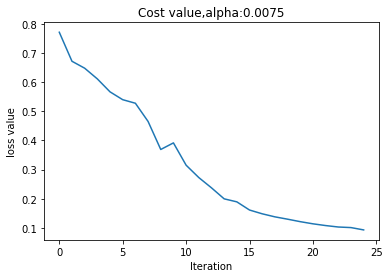

In [19]:
parameters,L = Model(train_x,train_y,[20,7,5,1],0.0075,2500,True)

可以看到模型的损失是逐渐降低的

### 9 score

我们来看看评分

In [20]:
def score(X,y,parameters,L):
    m = y.shape[1]
    A,cache = forward(X,parameters,L)
    
    predict = np.round(A)
    acc = (predict == y).sum() / m
    return acc

In [21]:
score(test_x,test_y,parameters,L)

0.8

In [22]:
score(train_x,train_y,parameters,L)

0.9856459330143541

可以看到,我们选择的超级参数:

layers:4

units:[20,7,5,1]

alpha: 0.0075

Iteration:2500

结果是可以接受的,当然你也可以尝试其他的层结构和超级参数,来查看是否有更好的结果.

## 10 Test with your own image
我们从网上来挑选一张图片来测试下

In [23]:
from skimage import transform

In [24]:
def predict(X,parameters,L):
    """
    predict label
    """
    A,cache = forward(X,parameters,L)
    predict = np.round(A)
    if np.squeeze(predict) == 1:
        print("It's cat.")
    else:
        print("Not cat")

加载图片

In [25]:
image_path = '../picture/cat.jpg'
image = plt.imread(image_path)

因为我们的训练样本是(64,64,3)的,所以我们需要将图片转换成一样的形式,当然在转换的过程中会丢失信息,我们将在后面进行阐述这方面的问题.

In [26]:
image_resize = transform.resize(image,output_shape=(64,64))

/Users/huwang/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/huwang/anaconda3/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


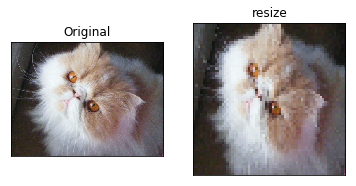

In [27]:
plt.subplot(1,2,1);plt.imshow(image);plt.title('Original');plt.xticks(());plt.yticks(())
plt.subplot(1,2,2);plt.imshow(image_resize);plt.title('resize');plt.xticks(());plt.yticks(())
plt.show()

最后我们来预测一下结果

In [28]:
test_X = image_resize.reshape(-1,1)
predict(test_X,parameters,L)

It's cat.


## Summary：
(1) 当成本函数下降的缓慢的时候,应该考虑初始参数和超级参数是否合适.

(2) 实际上我们在输出层上使用的激活函数(sigmoid):应该使得Z不可过大,如果过大,那么将进入sigmoid图像的平缓范围,那么在使用梯度下降求导的时候，会变得异常的缓慢,进而导致成本函数居高不下($Z=WX+b$),所以在初始化参数的时候,我们使用$Xavier\;Initialization$的形式.

(3) 使用ReLu激活函数的好处是,在多个隐藏层中使用ReLu的话会使得在大部分空间$Z$上,导数离0远,这样在使用GD的时候会产生更大的梯度,这会使得你的神经网络学习速度会快很多,因为其不像sigmoid和tanh函数斜率接近于0.